# Fuzzy Suitability Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

from rtree import index

from scipy.spatial import distance
import matplotlib.pyplot as plt

### Load data

In [2]:
farm = gpd.read_file(r"./raster/clip_farm.shp")
farm.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (249005.828 481581.281)
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,526231,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,613.0,POINT (248872.015 480167.536)
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,527052,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,625.0,POINT (246452.085 483617.636)
3,NaN,Rijksbeschermd,NaN,Ja,9916,onbekend,boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,652.0,POINT (248704.433 479914.870)
4,NaN,Gemeentelijk monument,NaN,Ja,BOR01032,onbekend,boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,671.0,POINT (248663.461 480092.868)


In [3]:
road = gpd.read_file(r"./raster/clip_road.shp")
road.head()

,u,v,key,highway,geometry
0,356,391,0,motorway,"LINESTRING (247574.767 478133.761, 247574.751 ..."
1,356,392,0,motorway_link,"LINESTRING (247703.431 478197.122, 247710.942 ..."
2,388,501,0,secondary,"LINESTRING (244106.110 481570.317, 244127.141 ..."
3,391,430,0,motorway_link,"LINESTRING (247106.336 478783.924, 247078.913 ..."
4,391,422,0,motorway,"LINESTRING (247106.336 478783.924, 247078.025 ..."


In [4]:
road = road.to_crs("EPSG:28992")

In [5]:
src = rasterio.open(r'./raster/agri_clip.tif')
lu = src.read(1)
src.close()

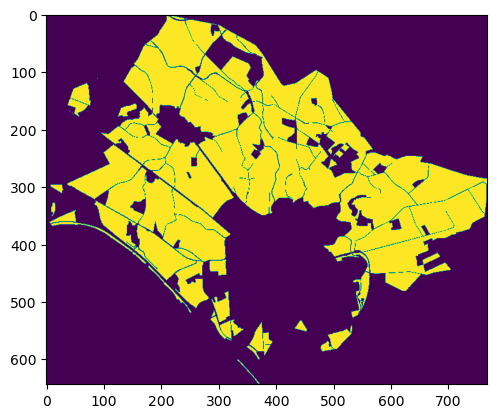

<Axes: >

In [6]:
show(lu)

In [7]:
lu.count

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [9]:
print(lu.width, lu.height)

AttributeError: 'numpy.ndarray' object has no attribute 'width'

In [ ]:
lu.indexes

(1,)

In [ ]:
band1 = lu.read(1)
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
band1[lu.height // 2, lu.width // 2]

4

In [8]:
lu.meta

AttributeError: 'numpy.ndarray' object has no attribute 'meta'

In [ ]:
# Load raster data
with rasterio.open(r'./raster/agri_clip.tif') as src:
    LU = src.read(1)  # Assuming it is a single band raster

In [14]:
LU.shape

(644, 768)

### Calculate distances

In [85]:
# Initialize an empty array to store the distances
distances_farm = np.ones_like(LU) * np.inf

In [86]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        cell_center = src.xy(row, col)
        point = Point(cell_center)

        # Calculate distances to farms
        for _, f in farm.iterrows():
            distance = point.distance(f.geometry)
            if distance < distances_farm[row, col]:
                distances_farm[row, col] = distance

In [90]:
distances_farm.shape

(644, 768)

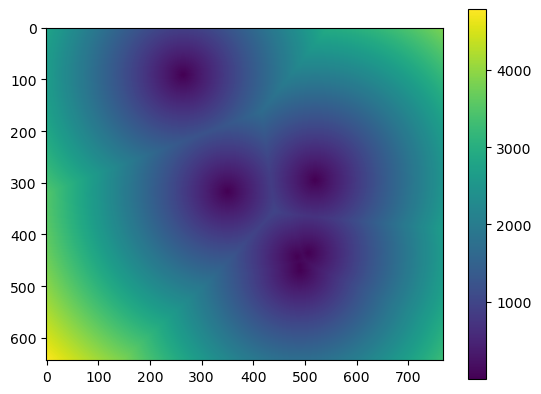

In [98]:
# Combine the distances with the original raster data
combined_raster = LU + distances_farm

# Visualize the combined raster
plt.imshow(combined_raster, cmap='viridis')
plt.colorbar()
plt.show()

In [104]:
distances_farm

array([[2801.20381912, 2791.75474907, 2782.30953017, ..., 3835.31828744,
        3841.71097946, 3848.11903837],
       [2797.95191824, 2788.49182884, 2779.03552014, ..., 3827.62738057,
        3834.03289608, 3840.45376642],
       [2794.7320153 , 2785.26098957, 2775.79367438, ..., 3819.94716756,
        3826.36554013, 3832.79925517],
       ...,
       [4774.41451472, 4767.07176396, 4759.73869525, ..., 3234.35668362,
        3242.84555723, 3251.34302392],
       [4781.20345713, 4773.87114854, 4766.54854032, ..., 3239.66046203,
        3248.13547445, 3256.61913824],
       [4788.003659  , 4780.68178014, 4773.36961981, ..., 3244.98638851,
        3253.44752728, 3261.9173754 ]])

### Rtree method

In [15]:
# Create spatial indexes for farms and roads
idx_farms = index.Index()
for i, f in farm.iterrows():
    idx_farms.insert(i, f.geometry.bounds)

In [16]:
# Create a mask to identify non-background values
background_value = 0  # Adjust this if the background value is different
mask = LU != background_value

In [17]:
d_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

In [18]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

        # Calculate distances to nearby farms using spatial indexing
            for j in idx_farms.nearest(cell_center, 1):
                f = farm.geometry.iloc[j]
                d = point.distance(f)
                if d < d_to_farm[row, col]:
                    d_to_farm[row, col] = d

In [105]:
# (distances_farm==distances_f).all() 

True

In [19]:
d_to_farm

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [36]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_farm.tif', 'w', **profile) as dst:
        dst.write(d_to_farm, 1)

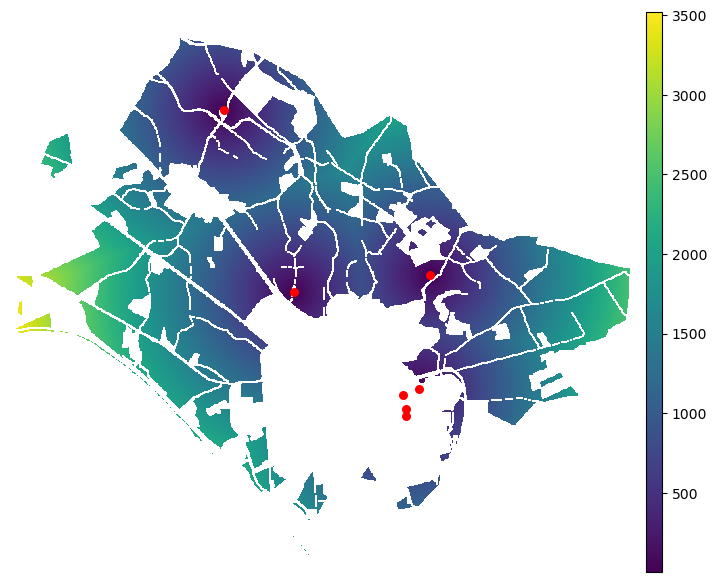

In [11]:
with rasterio.open(r'./raster/d_to_farm.tif') as src_farm:
    d_to_farm_raster = src_farm.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_farm, ax=ax)

    # Plot the farms
    farm.plot(ax=ax, marker='o', color='red', markersize=30)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')

    # Show the plot
    plt.show()

In [42]:
# if np.any(lu.read(1) > 0):
#     print("There are values larger than zero in the array.")
# else:
#     print("There are no values larger than zero in the array.")

### Distance to Road

In [43]:
# Create spatial indexes for roads
idx_roads = index.Index()
for i, r in road.iterrows():
    idx_roads.insert(i, r.geometry.bounds)

In [45]:
d_to_road = np.full_like(LU, np.inf, dtype=np.float64)

# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

        # Calculate distances to nearby farms using spatial indexing
            for j in idx_roads.nearest(cell_center, 1):
                r = road.geometry.iloc[j]
                d = point.distance(r)
                if d < d_to_road[row, col]:
                    d_to_road[row, col] = d

In [46]:
d_to_road

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [47]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_road.tif', 'w', **profile) as dst:
        dst.write(d_to_road, 1)

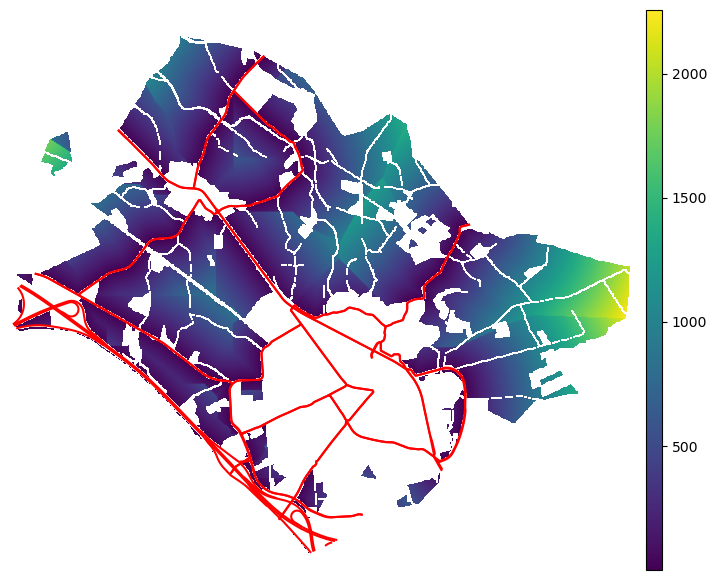

In [10]:
with rasterio.open(r'./raster/d_to_road.tif') as src_road:

    d_to_road_raster = src_road.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_road, ax=ax)

    # Plot the farms
    road.plot(ax=ax, color='red', )

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')

    # Show the plot
    plt.show()

## Fuzzy Suitability Analysis

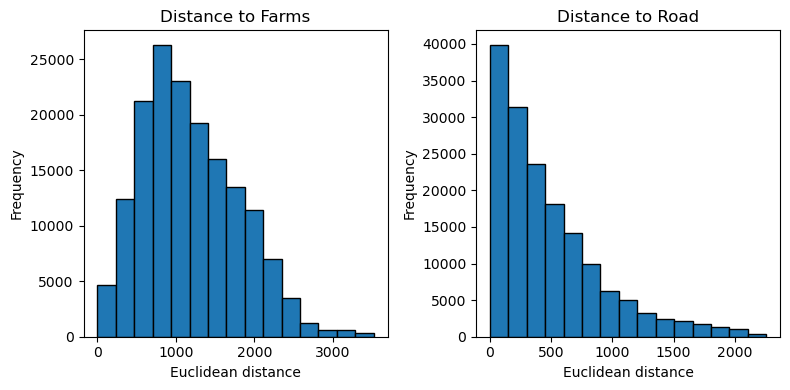

In [12]:
# Create subplots
plt.figure(figsize=(8, 4))

# Plot the first histogram
plt.subplot(1, 2, 1)
plt.hist(d_to_farm_raster[np.isfinite(d_to_farm_raster)], bins=15, edgecolor='black')
plt.title('Distance to Farms')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Plot the second histogram
plt.subplot(1, 2, 2)
plt.hist(d_to_road_raster[np.isfinite(d_to_road_raster)], bins=15, edgecolor='black')
plt.title('Distance to Road')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [17]:
d_to_farm_range = d_to_farm_raster[np.isfinite(d_to_farm_raster)] 
d_to_road_range = d_to_road_raster[np.isfinite(d_to_road_raster)]

In [19]:
len(d_to_farm_range)

160872

In [22]:
np.min(d_to_road_range), np.max(d_to_road_range)

(0.52243584, 2256.5605)

In [21]:
len(d_to_road_range)

160872

In [14]:
# Create fuzzy variables
fuzzy_farm = ctrl.Antecedent(d_to_farm_range, 'distance_to_farms')
fuzzy_road = ctrl.Antecedent(d_to_road_range, 'distance_to_roads')

In [95]:
# Define fuzzy membership functions using piecewise linear membership functions
fuzzy_farm['close'] = fuzz.piecemf(fuzzy_farm.universe, [0, 0, 5, 10], [1, 1, 0, 0])
fuzzy_farm['medium'] = fuzz.piecemf(fuzzy_farm.universe, [0, 5, 10], [0, 1, 0])
fuzzy_farm['far'] = fuzz.piecemf(fuzzy_farm.universe, [0, 5, 10, 10], [0, 0, 1, 1])


array([1049.4728, 1044.2915, 1024.2811, ..., 2102.061 , 2096.3408,
       2110.26  ], dtype=float32)

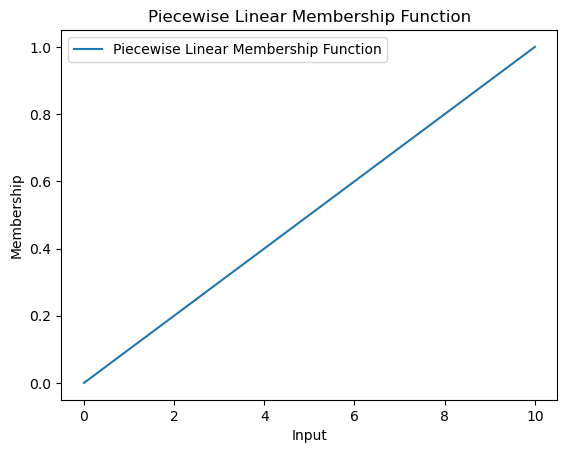

In [105]:
# Define the universe of discourse
x = np.arange(0, 11, 1)

# Define x and y coordinates for the piecewise linear function
xmf_points = [0, 5, 10]
ymf_points = [1, 0, 0]

# Create the piecewise linear membership function
membership_function = fuzz.piecemf(x, xmf_points)

# Plot the membership function
plt.plot(x, membership_function, label='Piecewise Linear Membership Function')
plt.title('Piecewise Linear Membership Function')
plt.xlabel('Input')
plt.ylabel('Membership')
plt.legend()
plt.show()

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


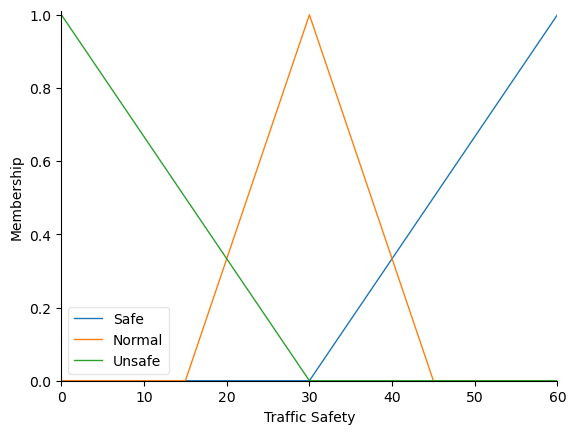

In [112]:
traffic_safety = ctrl.Antecedent(np.arange(0, 61, 1), 'Traffic Safety')
traffic_safety['Safe'] = fuzz.trimf(traffic_safety.universe, [30, 60, 60])
traffic_safety['Normal'] = fuzz.trimf(traffic_safety.universe, [15, 30, 45])
traffic_safety['Unsafe'] = fuzz.trimf(traffic_safety.universe, [0, 0, 30])
traffic_safety.view() 

In [138]:
# Create fuzzy variables
fuzzy_farm = ctrl.Antecedent(d_to_farm_range, 'distance_to_farms')
# fuzzy_farm['Far'] = fuzz.piecemf(fuzzy_farm.universe, [1000, np.max(d_to_farm_range), np.max(d_to_farm_range)])
# fuzzy_farm['Medium'] = fuzz.piecemf(fuzzy_farm.universe, [500, 1000, 1000])
# fuzzy_farm['Close'] = fuzz.piecemf(fuzzy_farm.universe, [0, 0, 500])
# fuzzy_farm = fuzz.piecemf(fuzzy_farm.universe, [0, 0, np.max(d_to_farm_range)])
a = np.min(d_to_farm_range)
linear_mf = fuzz.trapmf(fuzzy_farm, [a, a, a, 1000])
# Plot the membership function
plt.plot(x, linear_mf)
plt.title('Linear Fuzzy Membership Function using skfuzzy')
plt.xlabel('Input Variable')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

ValueError: Membership function '0' does not exist for Antecedent distance_to_farms.
Available options: 

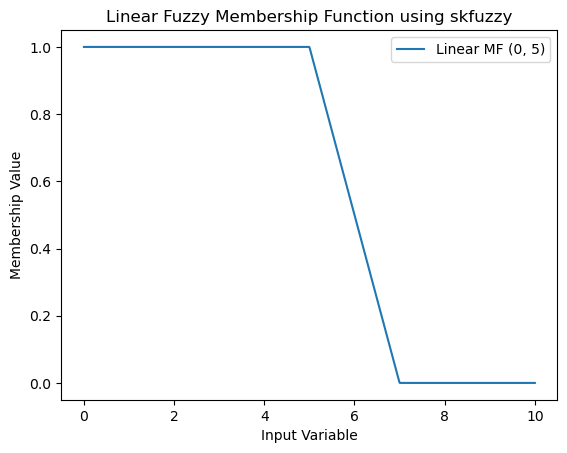

In [141]:
# Generate universe variables
x = np.linspace(0, 10, 1000)

# Generate the fuzzy membership function
a = 0
b = 5
c = 7
linear_mf = fuzz.trapmf(x, [a, a, b, c])

# Plot the membership function
plt.plot(x, linear_mf, label=f'Linear MF ({a}, {b})')
plt.title('Linear Fuzzy Membership Function using skfuzzy')
plt.xlabel('Input Variable')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

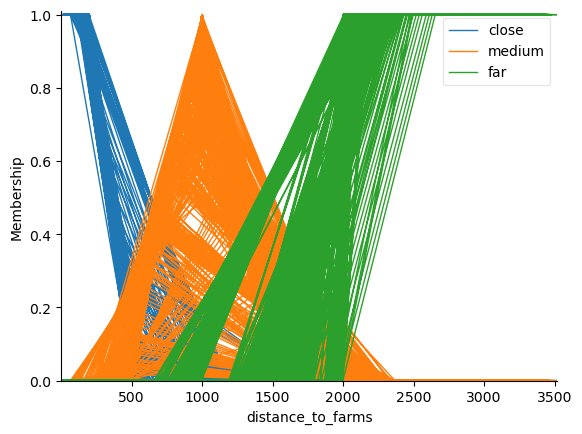

In [157]:
fuzzy_farm = ctrl.Antecedent(d_to_farm_range, 'distance_to_farms')

# # Create an Antecedent (input variable)
# fuzzy_farm = ctrl.Antecedent(np.linspace(0, 10, 100), 'FuzzyFarm')

# # Define parameters for the trapezoidal membership function
# a, b, c, d = 100, 500, 2000, np.max(d_to_farm_range)

# Define fuzzy sets
fuzzy_farm['close'] = fuzz.trapmf(fuzzy_farm.universe, [0, 0, 200, 500])
fuzzy_farm['medium'] = fuzz.trimf(fuzzy_farm.universe, [500, 1000, 1500])
fuzzy_farm['far'] = fuzz.trapmf(fuzzy_farm.universe, [2000, 2000, np.max(d_to_farm_range), np.max(d_to_farm_range)])

fuzzy_farm.view()

# # Plot the membership function
# plt.plot(x, linear_mf, label=f'Linear MF ({a}, {b})')
# plt.title('Linear Fuzzy Membership Function using skfuzzy')
# plt.xlabel('Input Variable')
# plt.ylabel('Membership Value')
# plt.legend()
# plt.show()

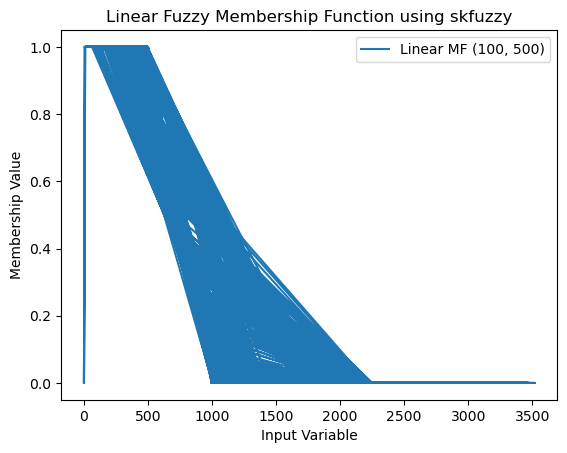

In [161]:
# Generate universe variables
# fuzzy_farm = ctrl.Antecedent(d_to_farm_range, 'distance_to_farms')

fuzzy_farm = fuzz.trapmf(d_to_farm_range, [3, 3, 500, 1000])

# Plot the membership function
# Plot the membership function
plt.plot(d_to_farm_range, fuzzy_farm, label=f'Linear MF ({a}, {b})')
plt.title('Linear Fuzzy Membership Function using skfuzzy')
plt.xlabel('Input Variable')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


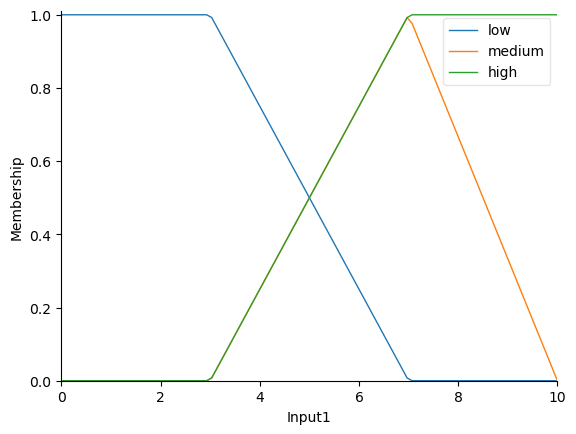

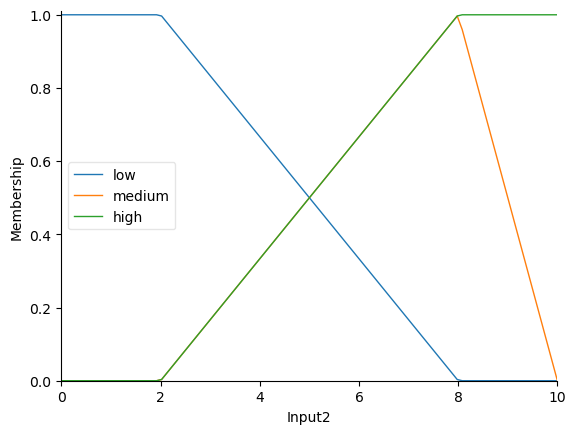

In [15]:
# Create Antecedents (input variables)
input1 = ctrl.Antecedent(np.linspace(0, 10, 100), 'Input1')
input2 = ctrl.Antecedent(np.linspace(0, 10, 100), 'Input2')

# Define fuzzy membership functions for the inputs
a1, b1 = 3, 7
input1['low'] = fuzz.trapmf(input1.universe, [0, 0, a1, b1])
input1['medium'] = fuzz.trimf(input1.universe, [a1, b1, 10])
input1['high'] = fuzz.trapmf(input1.universe, [a1, b1, 10, 10])
input1.view() 

a2, b2 = 2, 8
input2['low'] = fuzz.trapmf(input2.universe, [0, 0, a2, b2])
input2['medium'] = fuzz.trimf(input2.universe, [a2, b2, 10])
input2['high'] = fuzz.trapmf(input2.universe, [a2, b2, 10, 10])
input2.view() 

# Example usage:
input1_value = 5
input2_value = 6

In [57]:
# # Your farm and road arrays
# farm_distances = np.array(...)  # Replace ... with your actual farm distances array
# road_distances = np.array(...)  # Replace ... with your actual road distances array

# Farm distance
farm_distance = ctrl.Antecedent(d_to_farm_range, 'farm_distance')
farm_distance['close'] = fuzz.trimf(farm_distance.universe, [d_to_farm_range.min(), 100, 500])  # Adjust some_value based on your data
farm_distance['medium'] = fuzz.trimf(farm_distance.universe, [450, 750, 1000])
farm_distance['far'] = fuzz.trimf(farm_distance.universe, [750, 1000, d_to_farm_range.max()])

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


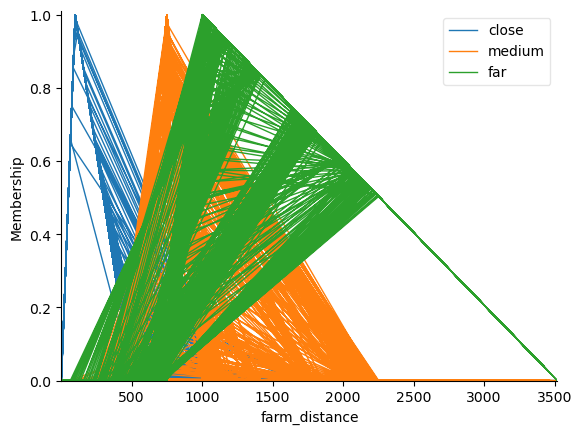

In [46]:
farm_distance.view()

/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


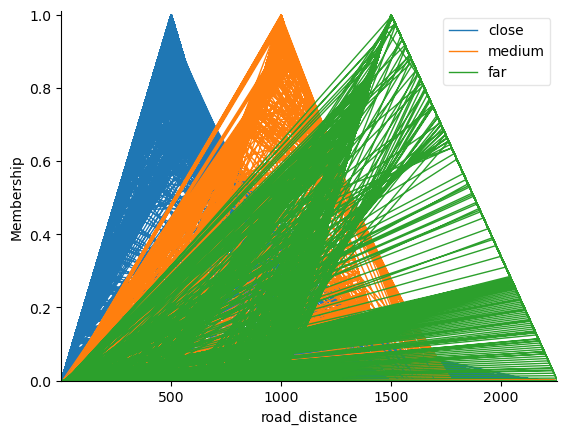

In [58]:
# Road distance
road_distance = ctrl.Antecedent(d_to_road_range, 'road_distance')
road_distance['close'] = fuzz.trimf(road_distance.universe, [d_to_road_range.min(), 500, 1000])  # Adjust some_value based on your data
road_distance['medium'] = fuzz.trimf(road_distance.universe, [500, 1000, 1500])
road_distance['far'] = fuzz.trimf(road_distance.universe, [1000, 1500, d_to_road_range.max()])
road_distance.view()

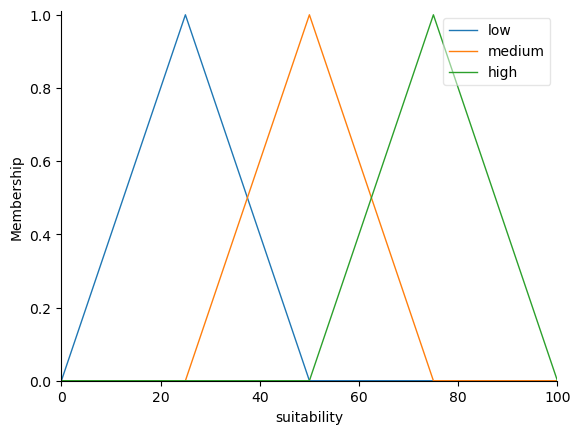

In [59]:
# Suitability
suitability = ctrl.Consequent(np.arange(0, 101, 1), 'suitability')
suitability['low'] = fuzz.trimf(suitability.universe, [0, 25, 50])
suitability['medium'] = fuzz.trimf(suitability.universe, [25, 50, 75])
suitability['high'] = fuzz.trimf(suitability.universe, [50, 75, 100])
suitability.view()

In [60]:
rule1 = ctrl.Rule(farm_distance['close'] & road_distance['close'], suitability['high'])
rule2 = ctrl.Rule(farm_distance['medium'] & road_distance['medium'], suitability['medium'])
rule3 = ctrl.Rule(farm_distance['far'] & road_distance['far'], suitability['low'])
# rule4 = ctrl.Rule(farm_distance['medium'] & road_distance['far'], suitability['low'])
# rule5 = ctrl.Rule(farm_distance['far'] & road_distance['medium'], suitability['low'])
# rule6 = ctrl.Rule(farm_distance['close'] & road_distance['medium'], suitability['medium'])
# rule6 = ctrl.Rule(farm_distance['medium'] & road_distance['close'], suitability['medium'])

In [61]:
# Create the fuzzy control system and add the rules:
suitability_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
suitability_evaluator = ctrl.ControlSystemSimulation(suitability_ctrl)

In [43]:
d_to_road_range[100]

887.26013

In [62]:
suitability_evaluator.input['farm_distance'] = d_to_farm_range[100]
suitability_evaluator.input['road_distance'] = d_to_road_range[100]

suitability_evaluator.compute()

ValueError: Crisp output cannot be calculated, likely because the system is too sparse. Check to make sure this set of input values will activate at least one connected Term in each Antecedent via the current set of Rules.

In [53]:
print(farm_distance.universe)
print(road_distance.universe)
print("Farm distances range:", d_to_farm_range.min(), "to", d_to_farm_range.max())
print("Road distances range:", d_to_road_range.min(), "to", d_to_road_range.max())

[1049.4728 1044.2915 1024.2811 ... 2102.061  2096.3408 2110.26  ]
[950.7839   943.783    891.4417   ...  17.407125   9.566364  23.613773]
Farm distances range: 2.0972998 to 3519.5596
Road distances range: 0.52243584 to 2256.5605


In [56]:
# Linear membership functions
def linear(x, a, b):
    return np.maximum(0, 1 - (x - a) / (b - a))

In [67]:
# Define membership functions for farm distances
farm_close = linear(d_to_farm_range, a=0, b=500)
farm_medium = linear(d_to_farm_range, a=450, b=1000)
farm_far = linear(d_to_farm_range, a=950, b=d_to_farm_range.max())

In [68]:
# Normalize membership functions to ensure y-axis range between 0 and 1
farm_close /= farm_close.max()
farm_medium /= farm_medium.max()
farm_far /= farm_far.max()

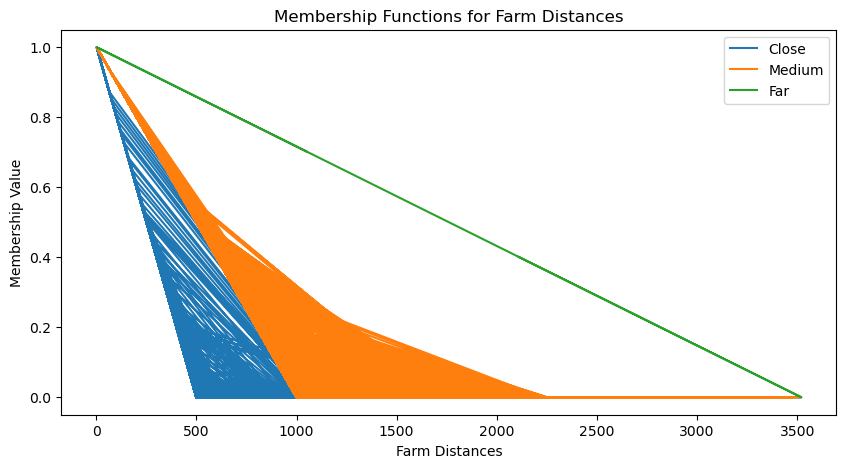

In [69]:
# Plot membership functions for farm distances
plt.figure(figsize=(10, 5))
plt.plot(d_to_farm_range, farm_close, label='Close')
plt.plot(d_to_farm_range, farm_medium, label='Medium')
plt.plot(d_to_farm_range, farm_far, label='Far')
plt.title('Membership Functions for Farm Distances')
plt.xlabel('Farm Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

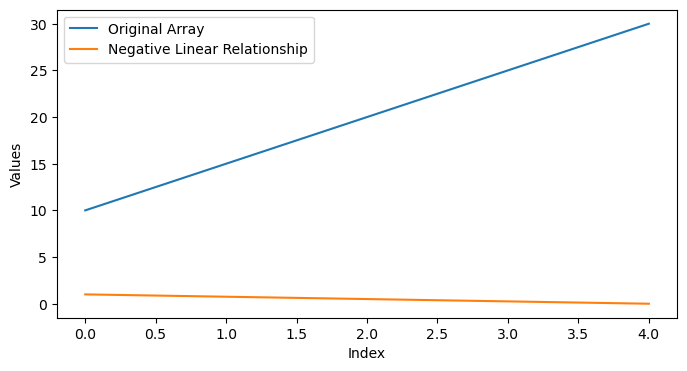

In [71]:

# Generate an example numpy array
your_array = np.array([10, 15, 20, 25, 30])

# Min-Max normalization
normalized_values = (your_array - your_array.min()) / (your_array.max() - your_array.min())

# Create a negative linear relationship
negative_linear_values = 1 - normalized_values

# Plot the original array and the negative linear relationship
plt.figure(figsize=(8, 4))
plt.plot(your_array, label='Original Array')
plt.plot(negative_linear_values, label='Negative Linear Relationship')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [75]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm_range - d_to_farm_range.min()) / (d_to_farm_range.max() - d_to_farm_range.min()))

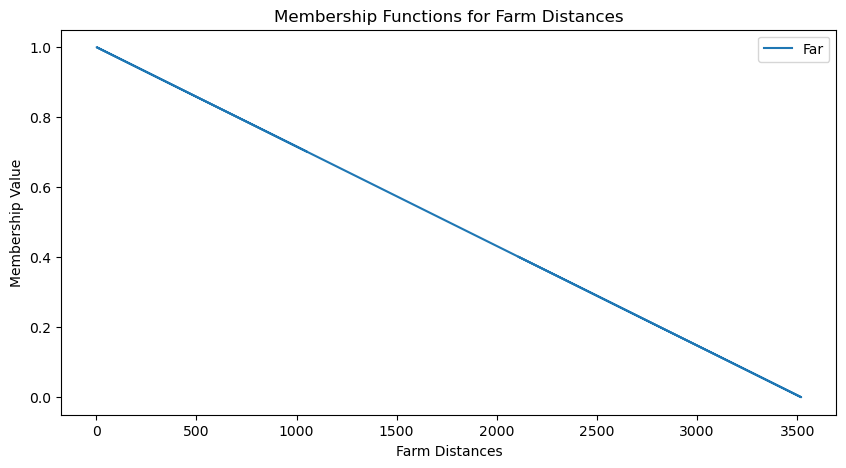

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(d_to_farm_range, fuzzy_farm, label='Far')
plt.title('Membership Functions for Farm Distances')
plt.xlabel('Farm Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

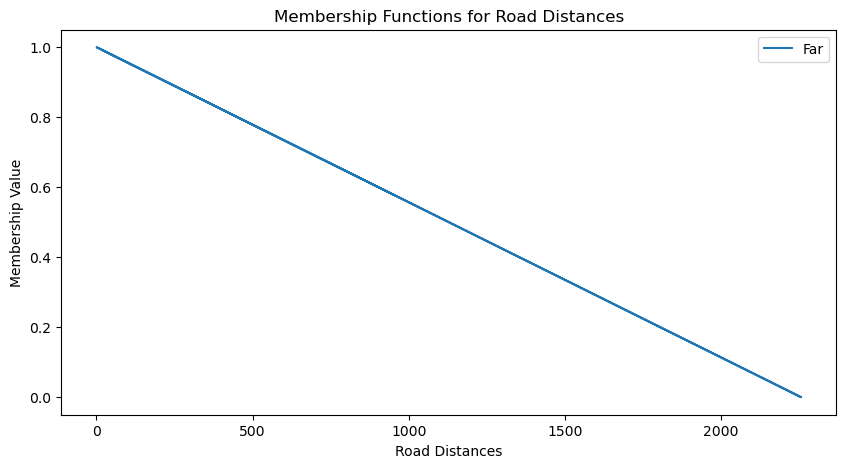

In [78]:
fuzzy_road = np.maximum(0, 1 - (d_to_road_range - d_to_road_range.min()) / (d_to_road_range.max() - d_to_road_range.min()))
plt.figure(figsize=(10, 5))
plt.plot(d_to_road_range, fuzzy_road, label='Far')
plt.title('Membership Functions for Road Distances')
plt.xlabel('Road Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

In [83]:
# Fuzzy operation AND
fuzzy_and = np.minimum(fuzzy_farm, fuzzy_road)

In [132]:
# Find indices where array0 is not inf
non_inf_indices = np.where(np.isfinite(d_to_farm_raster))
non_inf_indices

(array([  2,   2,   2, ..., 642, 642, 643]),
 array([210, 211, 215, ..., 370, 371, 370]))

In [135]:
assert len(fuzzy_and) == len(non_inf_indices[0])

In [136]:
m = np.copy(d_to_farm_raster)

In [137]:
# Replace values in result_array with corresponding values from array1
m[non_inf_indices] = fuzzy_and

In [143]:
# Open the original raster file
with rasterio.open(r'./raster/agri_clip.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/fuzzy_and_1.tif', 'w', **profile) as dst:
        dst.write(m, 1)

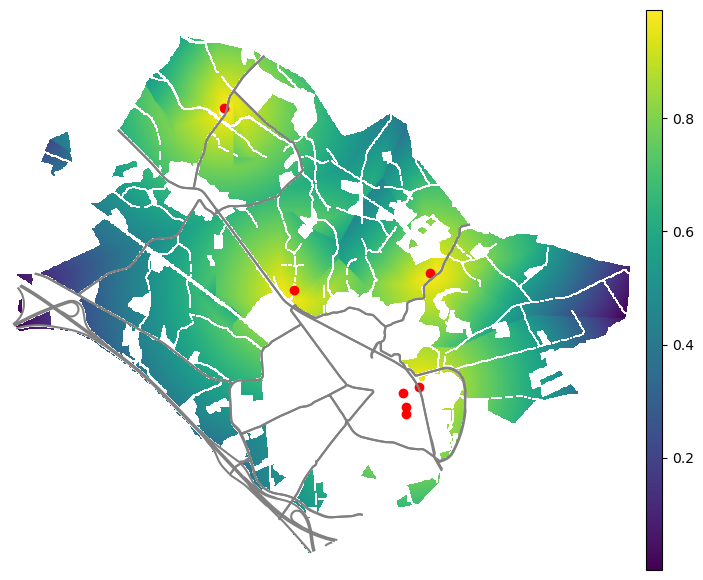

In [146]:
with rasterio.open(r'./raster/fuzzy_and_1.tif') as src:

    fuzzy = src.read(1)

    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    road.plot(ax=ax, color='grey')
    farm.plot(ax=ax, color='red')

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    plt.show()